In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
def load_and_prepare_data(base_dir, max_sequence_length=None):
    sequences = []
    labels = []

    for label_dir in ['true', 'false']:
        label_path = os.path.join(base_dir, label_dir)
        label = 1 if label_dir == 'true' else 0  # true 디렉토리 1, false 디렉토리 0

        print(f"Processing directory: {label_dir} with label {label}")

        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            if file_name.endswith('.csv'):
                data = pd.read_csv(file_path, delimiter=',')
                
                if data.empty:
                    print(f"  Warning: {file_name} is empty or invalid, skipping this file.")
                    continue

                # 표준화
                scaler = StandardScaler()
                data = scaler.fit_transform(data)
                
                sequences.append(data)
                labels.append(label)
    
    # 시퀀스 길이 맞추기 (패딩추가)
    if max_sequence_length is None:
        max_sequence_length = max(len(seq) for seq in sequences)

    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', dtype='float32')

    return np.array(padded_sequences), np.array(labels), max_sequence_length

In [3]:
def create_sliding_windows(data, labels, window_size, stride=20):
    num_samples = data.shape[0]
    num_timesteps = data.shape[1]
    num_features = data.shape[2]
    
    windows = []
    window_labels = []

    for i in range(num_samples):
        actual_length = np.count_nonzero(np.any(data[i], axis=1))  # 실제 데이터 길이 계산
        sample_windows_count = 0
        for start in range(0, actual_length - window_size + 1, stride):
            end = start + window_size
            window = data[i, start:end, :]
            windows.append(window)
            window_labels.append(labels[i])
            sample_windows_count += 1

    return np.array(windows), np.array(window_labels)

In [4]:
import matplotlib.pyplot as plt

base_dir = '../training_data'
X, y, max_len = load_and_prepare_data(base_dir)

# 슬라이딩 윈도우 적용
window_size = 100
X_windows, y_windows = create_sliding_windows(X, y, window_size)

print("Original:", X.shape)
print("after x_windows:", X_windows.shape)
print("after y_windows:", y_windows.shape)

unique_labels, counts = np.unique(y_windows, return_counts=True)
label_count_dict = dict(zip(unique_labels, counts))

for label, count in label_count_dict.items():
    print(f'Label {label}: {count} windows')

import numpy as np

def check_original_lengths(base_dir):
    lengths = {'label_0': [], 'label_1': []}
    
    for label_dir in ['true', 'false']:
        label_path = os.path.join(base_dir, label_dir)
        label = 'label_1' if label_dir == 'true' else 'label_0'

        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            if file_name.endswith('.csv'):
                data = pd.read_csv(file_path, delimiter=',')
                lengths[label].append(len(data))
    
    return lengths

base_dir = '../training_data'
lengths = check_original_lengths(base_dir)

# 합산 길이 계산
sum_length_label_0 = np.sum(lengths['label_0'])
sum_length_label_1 = np.sum(lengths['label_1'])

print(f"Total length - 0 (일상): {sum_length_label_0}")
print(f"Total length - 1 (낙상): {sum_length_label_1}")

Processing directory: true with label 1
Processing directory: false with label 0
Original: (990, 20000, 6)
after x_windows: (70518, 100, 6)
after y_windows: (70518,)
Label 0: 56688 windows
Label 1: 13830 windows
Total length - 0 (일상): 1143182
Total length - 1 (낙상): 354408


In [5]:
def generator(X, y, window_size):
    for i in range(len(y)):
        yield X[i], y[i]

batch_size = 32

dataset = tf.data.Dataset.from_generator(
    lambda: generator(X_windows, y_windows, window_size),
    output_signature=(
        tf.TensorSpec(shape=(window_size, X_windows.shape[2]), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
)

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X_windows, y_windows, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42) 

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

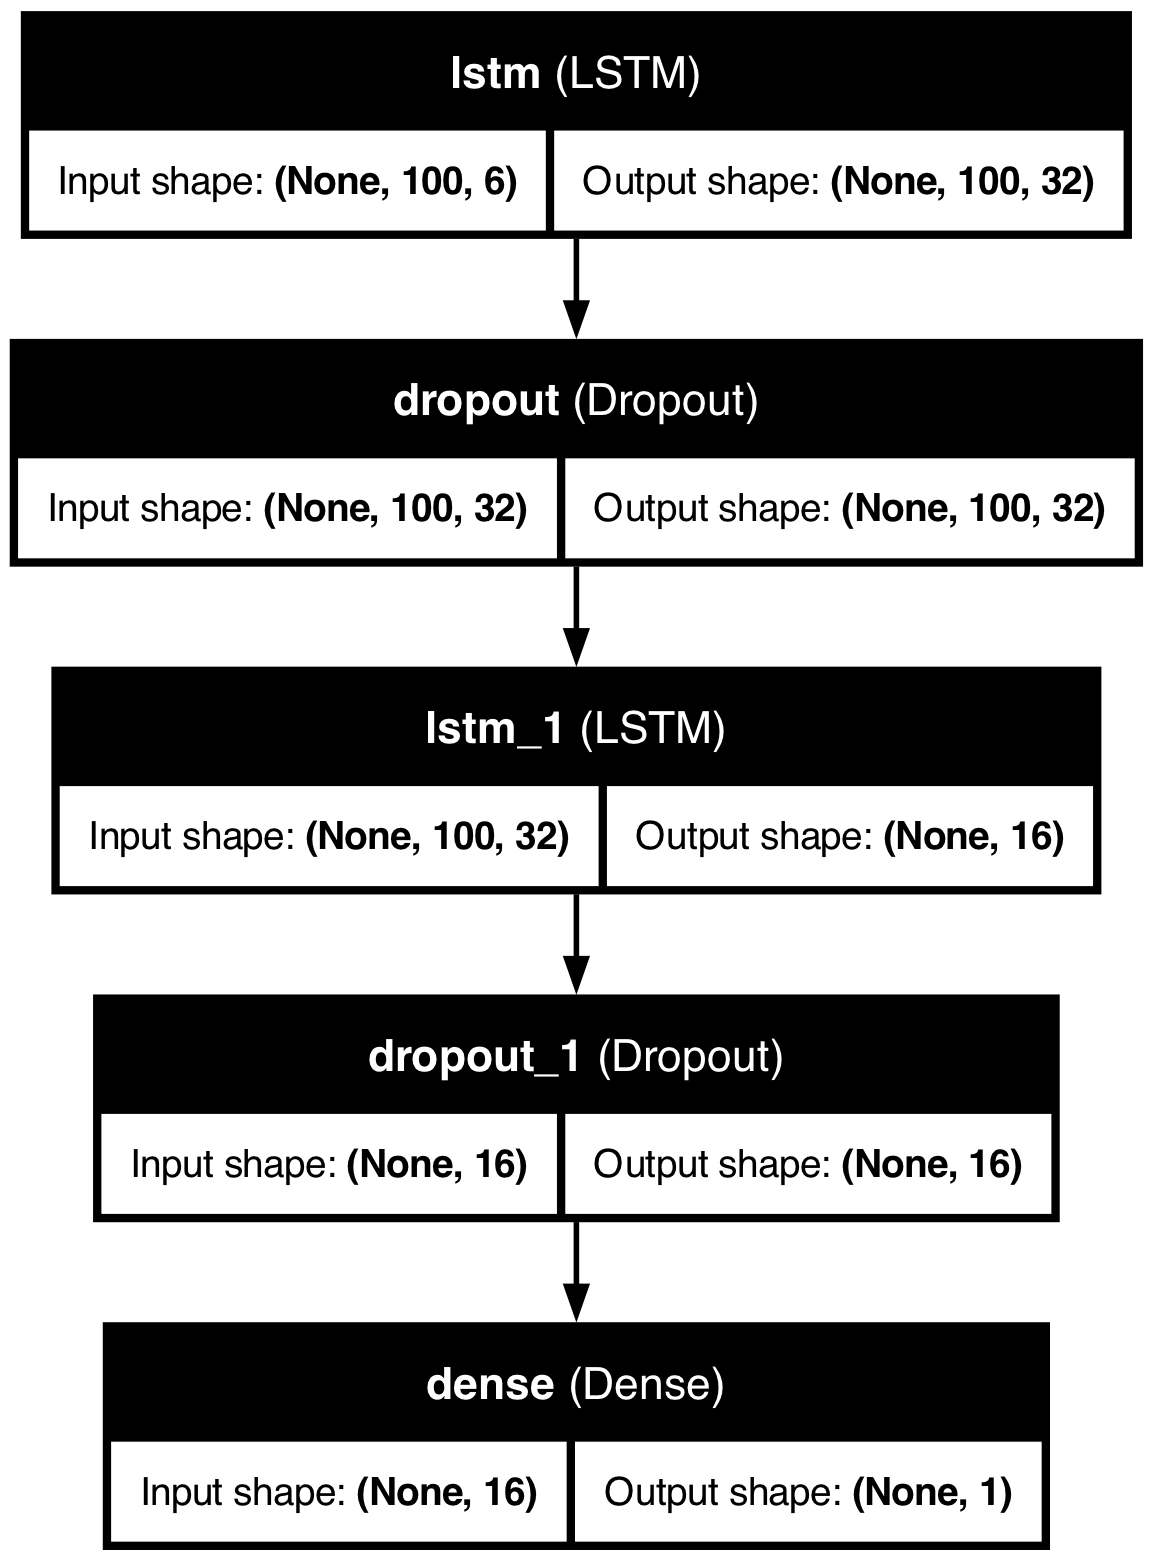

In [7]:
model = Sequential()
model.add(Input(shape=(window_size, X_windows.shape[2])))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))  
model.add(LSTM(16, return_sequences=False)) 
model.add(Dropout(0.2)) 
model.add(Dense(units=1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
plot_model(model, to_file='model2.png', show_shapes=True, show_layer_names=True)

In [8]:
from sklearn.utils.class_weight import compute_class_weight

# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_windows), y=y_windows)
class_weights = dict(enumerate(class_weights))

history = model.fit(train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset, 
                    steps_per_epoch=len(X_train) // batch_size,
                    class_weight=class_weights)

Epoch 1/50
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - accuracy: 0.7291 - loss: 0.5497 - val_accuracy: 0.8112 - val_loss: 0.4004
Epoch 2/50
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.8456 - loss: 0.3551 - val_accuracy: 0.8723 - val_loss: 0.3176
Epoch 3/50
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.8866 - loss: 0.2838 - val_accuracy: 0.8820 - val_loss: 0.2917
Epoch 4/50
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.9011 - loss: 0.2511 - val_accuracy: 0.9260 - val_loss: 0.1975
Epoch 5/50
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.9153 - loss: 0.2320 - val_accuracy: 0.9448 - val_loss: 0.1529
Epoch 6/50
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.9260 - loss: 0.1918 - val_accuracy: 0.9207 - val_loss: 0.2251
Epoch 7/50
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.9119 - loss: 0.2199 - val_accuracy: 0.9398 - val_loss: 0.1626
Epoch 8/50
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.9362 -

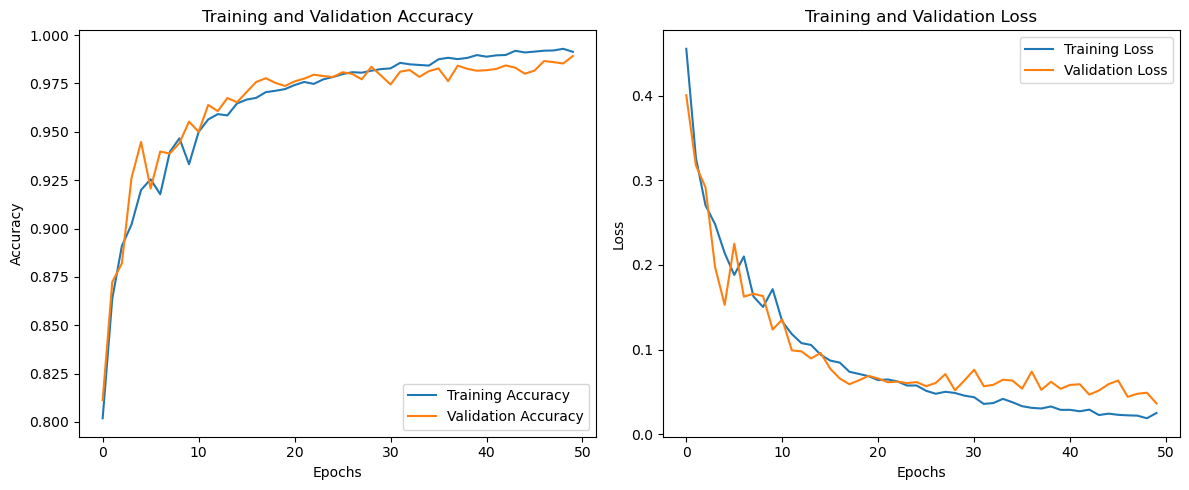

In [9]:
import matplotlib.pyplot as plt

def plot_training_history(history, save=None):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history, save="../images/learning_result/result8.png")

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Test Accuracy: 0.9891148668003438
Confusion Matrix (Test Data):
[[5575   50]
 [  26 1331]]
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5625
           1       0.96      0.98      0.97      1357

    accuracy                           0.99      6982
   macro avg       0.98      0.99      0.98      6982
weighted avg       0.99      0.99      0.99      6982



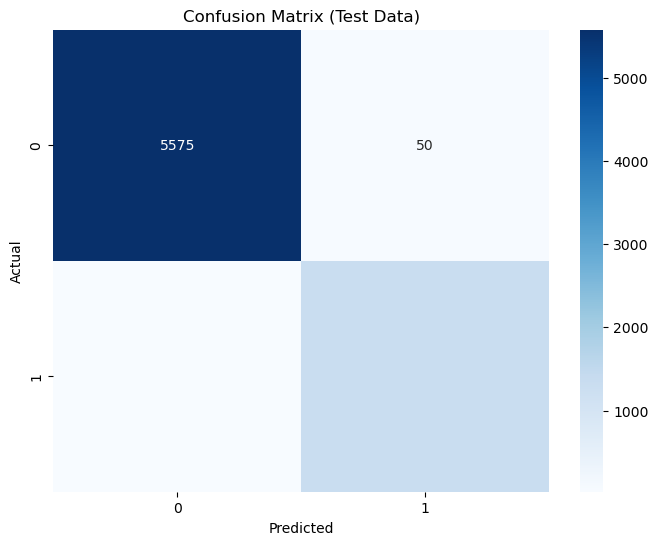

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_test_pred = model.predict(X_test)
y_test_pred = (y_test_pred > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

test_conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Data):")
print(test_conf_matrix)

# 분류 보고서 출력
test_class_report = classification_report(y_test, y_test_pred)
print("Classification Report (Test Data):")
print(test_class_report)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

save_path = "../images/learning_result/test_result8.png"
plt.savefig(save_path)

plt.show()

In [11]:
model.save('../LSTM_model/model_3.keras')